In [1]:
import ChromoGen
from ChromoGen.model.Diffuser.training_utils import ConfigDataset
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
plt.style.use('../support/plot_style.txt')

2024-11-20 14:26:28.264434: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Filepaths

In [2]:
gm_mcool = '../../outside_data/hic/GM12878_hg19.mcool'
imr_mcool = '../../outside_data/hic/IMR90_hg19.mcool'

# If you change the following to the regenerated data path, note that aligned structures will be different
# than those in the paper because we unfortunately didn't manually set the random seed when generating our data. 
cgen_conformations_dir = '../../downloaded_data/conformations/ChromoGen/specific_regions/' 
formatted_dipc_data = '../../downloaded_data/conformations/DipC/processed_data.h5'
dcd_data_dir = './vmd_visualization/dcd_files/'
pdf_dir = './pdfs/'

Check if files exist. Initialize Hi-C objects

In [3]:
# This simultaneously checks that a file exists. If they don't, run the script 
# ChromoGen/recreate_results/outside_data/hic/download_and_process.sh
hic_datasets = {
    'GM12878':ChromoGen.data_utils.HiCDataset(gm_mcool,resolution=20_000),
    'IMR-90':ChromoGen.data_utils.HiCDataset(imr_mcool,resolution=20_000)
}

# data directories. More likely to exist if you cloned the repo. 
cgen_conformations_dir = Path(cgen_conformations_dir)
assert cgen_conformations_dir.exists()

formatted_dipc_data = Path(formatted_dipc_data)
assert formatted_dipc_data.exists()

dcd_data_dir = Path(dcd_data_dir)
dcd_data_dir.mkdir(exist_ok=True,parents=True)

pdf_dir = Path(pdf_dir)
pdf_dir.mkdir(exist_ok=True,parents=True)

#### Fetch the Dip-C data

In [4]:
config_ds = ConfigDataset(
    str(formatted_dipc_data),
    segment_length=64,
    remove_diagonal=False,
    batch_size=0,
    normalize_distances=False, 
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=None, 
    replicates=None,
    shuffle=False,
    allow_overlap=True,
    two_channels=False,
    try_GPU=False,
    mean_dist_fp=None,
    mean_sq_dist_fp=None
)

#### Function that we'll use to plot Hi-C & distance maps

In [5]:
def make_plot(
    cell_type,
    chrom,
    start_idx,
    aligned_cgen_idx,
    aligned_dipc_idx,
    *,
    ax_titles=True,
    fig=None,
    hic_ax=None,
    dist_ax=None,
    fit_ax=None,
    cbar_orientation='horizontal',
    resolution=20_000
):

    ##############################
    # Collect the relevant data

    ###
    # ChromoGen-inferred conformations

    # Filepaths
    f1 = cgen_conformations_dir / cell_type.replace('-','')
    f2 = f1 / f'chrom_{chrom}/start_idx_{start_idx//1000}_cond_scale_5.0_rescaled_phi_8.0.pt'
    f1 = f1 / f'chrom_{chrom}/start_idx_{start_idx//1000}_cond_scale_1.0_rescaled_phi_0.0.pt'

    # Load
    # drop_invalid_conformations=True will have this drop any conformations containing NaN values
    cgen_coords = ChromoGen.Conformations(f1,drop_invalid_conformations=True).cat(
        ChromoGen.Conformations(f2,drop_invalid_conformations=True)
    )

    # Get the distance map for the aligned structure
    cgen_aligned_dists = cgen_coords[aligned_cgen_idx].distances

    # Get median distances
    cgen_median_dists = cgen_coords.distances.median.float()
    del cgen_coords

    # Convert to nm
    cgen_median_dists = ChromoGen.Conformations(cgen_median_dists.values * 100).float()

    ###
    # Dip-C conformations

    # Load
    dipc_coords = ChromoGen.Conformations(config_ds.fetch_specific_coords(chrom,start_idx)[-1])

    # Get the distance map for the aligned structure
    dipc_aligned_dists = dipc_coords[aligned_dipc_idx].distances.float()

    # Get median distances
    dipc_median_dists = dipc_coords.distances.median.float()
    del dipc_coords
    
    # Convert to nm
    dipc_median_dists = ChromoGen.Conformations(dipc_median_dists.values * 100)

    ###
    # Experimental Hi-C
    hic_map = hic_datasets[cell_type].fetch(chrom,start_idx,start_idx + dipc_median_dists.num_beads*resolution,balance = True)

    ##############################
    # Plot

    ###
    # Initialize the figure (if needed)
    if fig is None or hic_ax is None or dist_ax is None or fit_ax is None:
        if cbar_orientation is None:
            fig,(hic_ax,dist_ax,fit_ax)=plt.subplots(ncols=3, nrows=1, figsize=(7.08*.6,6.692*.25),layout="constrained")
        else:
            fig,(hic_ax,dist_ax,fit_ax)=plt.subplots(ncols=3, nrows=1, figsize=(7.08*.5,6.692*.25),layout="constrained")

    ###
    # Plot the Hi-C map 
    _,_,hic_im,hic_cbar = hic_map.plot(fig=fig,ax=hic_ax,vmax=1,cbar_orientation=cbar_orientation)

    ###
    # Plot the median distance maps
    
    # Prepare to format the colorbar
    if cbar_orientation is None:
        cbar_ticks = None
    else:
        cbar_tick_max = int(max(dipc_median_dists.values.max(),cgen_median_dists.values.max())//100 * 100)
        cbar_ticks = [0,cbar_tick_max]

    # Plot
    _,_,dist_im,dist_cbar = dipc_median_dists.plot_with(
        cgen_median_dists,fig=fig,ax=dist_ax,cbar_orientation=cbar_orientation,cbar_ticks=cbar_ticks
    )

    ###
    # The aligned conformations' distance maps
    if cbar_orientation is None:
        cbar_ticks = None
    else:
        cbar_tick_max = int(max(dipc_aligned_dists.values.max(),cgen_aligned_dists.values.max())//100 * 100)
        cbar_ticks = [0,cbar_tick_max]
    
    _,_,fit_im, fit_cbar = dipc_aligned_dists.plot_with(
        cgen_aligned_dists,fig=fig,ax=fit_ax,cbar_orientation=cbar_orientation,cbar_ticks=cbar_ticks, 
    )

    ###
    # Clear the labels so that 
    
    # Drop the y-label on distance plots since the Hi-C plot on the left handles this
    dist_ax.set_ylabel('')
    fit_ax.set_ylabel('')

    # Clear the automatic colorbar labels & just handle them in the loop calling this function
    hic_cbar.set_label('')
    dist_cbar.set_label('')
    fit_cbar.set_label('')

    # Set the figure title. Use Mb for genomic indices to improve readability
    n = cgen_median_dists.num_beads
    start_Mb = round(start_idx/1e6,3)
    stop_Mb = round((start_idx+resolution*n)/1e6,3)
    fig.suptitle(
        '\n'+f'Chromosome {chrom}: {start_Mb}-{stop_Mb} Mb',
        verticalalignment='center'
    )

    # Label ChromoGen & Dip-C on lower/upper triangle of each map for clarity
    for ax in [dist_ax,fit_ax]:
        
        ax.text(.995*n-1,.005*n,'Dip-C',horizontalalignment='right',verticalalignment='top',
                color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")],fontsize='small')
        
        ax.text(.005*n,.995*n-1,'ChromoGen',horizontalalignment='left',verticalalignment='baseline',
                color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")],fontsize='small')

    return fig, hic_ax, dist_ax, fit_ax, hic_cbar, dist_cbar, fit_cbar #dist_ax, dist_im, dist_cbar, hic_ax, hic_im, hic_cbar
    

#### Make the left three panels of each figure

Note that there are some overlapping labels, etc., here but not in the manuscript. That's because I moved them around in Adobe Illustrator afterwards. 

Similarly, I added the "Experimental Hi-C", "Population median", and "Aligned conformation" titles in Illustrator. 

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 29 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'G', 'M', 'b', 'c', 'colon', 'd', 'e', 'eight', 'h', 'hyphen', 'i', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'six', 'space', 'two', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 25, 27, 28, 29, 38, 42, 48, 69, 70, 71, 72, 75, 76, 80, 81, 82, 85, 86, 91, 1894]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 29 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'G', 'M', 'b', 'c', 'colon', 'd', 'e', 'eight', 'h', 'hyphen', 'i',

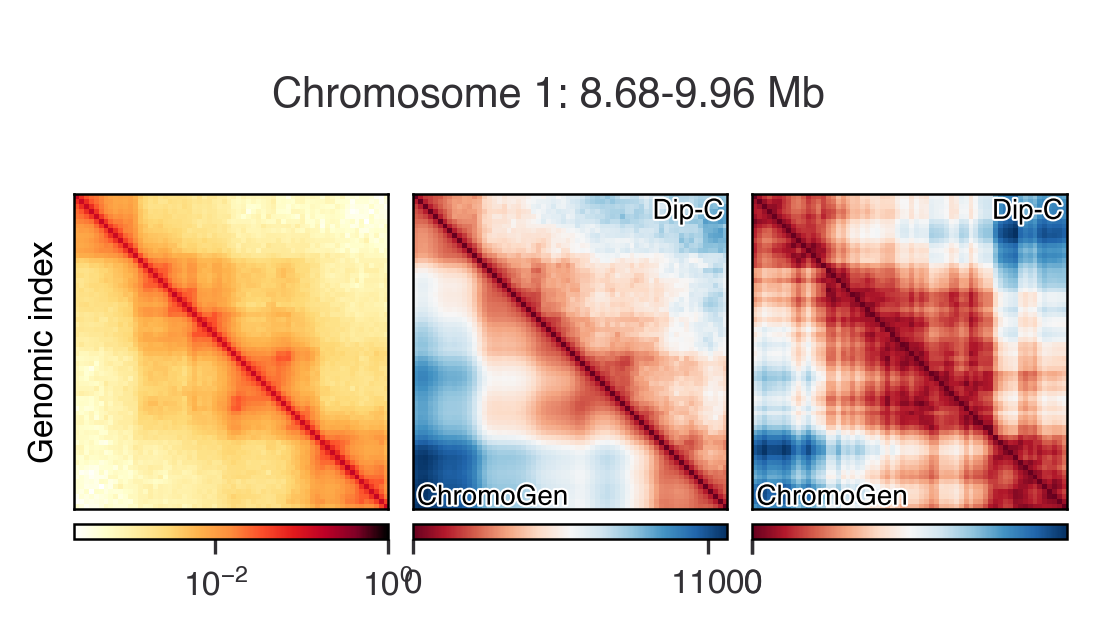

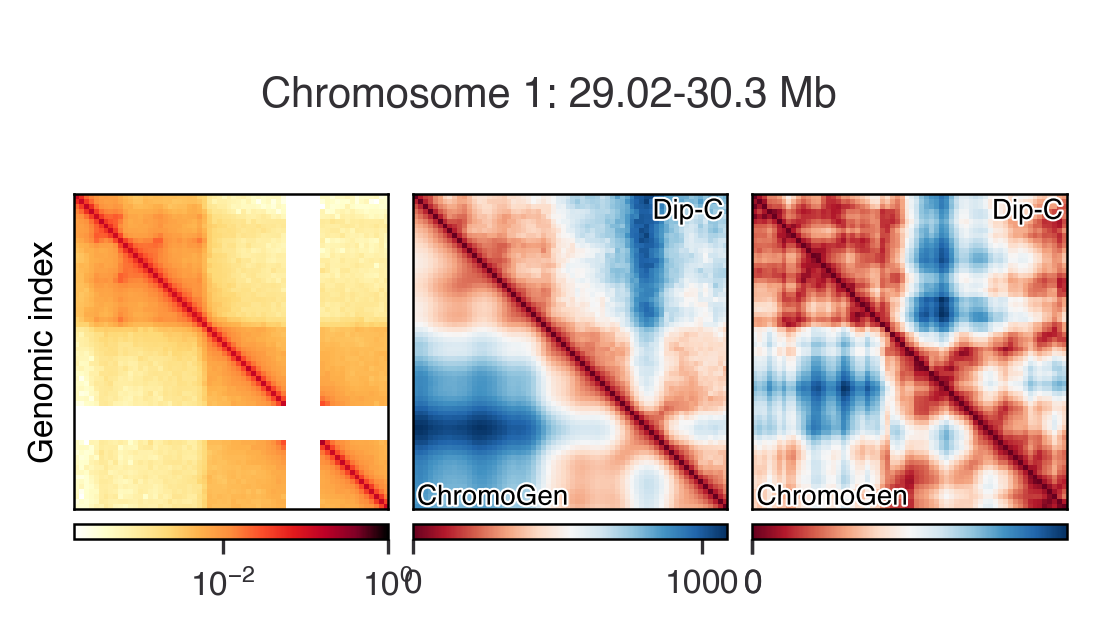

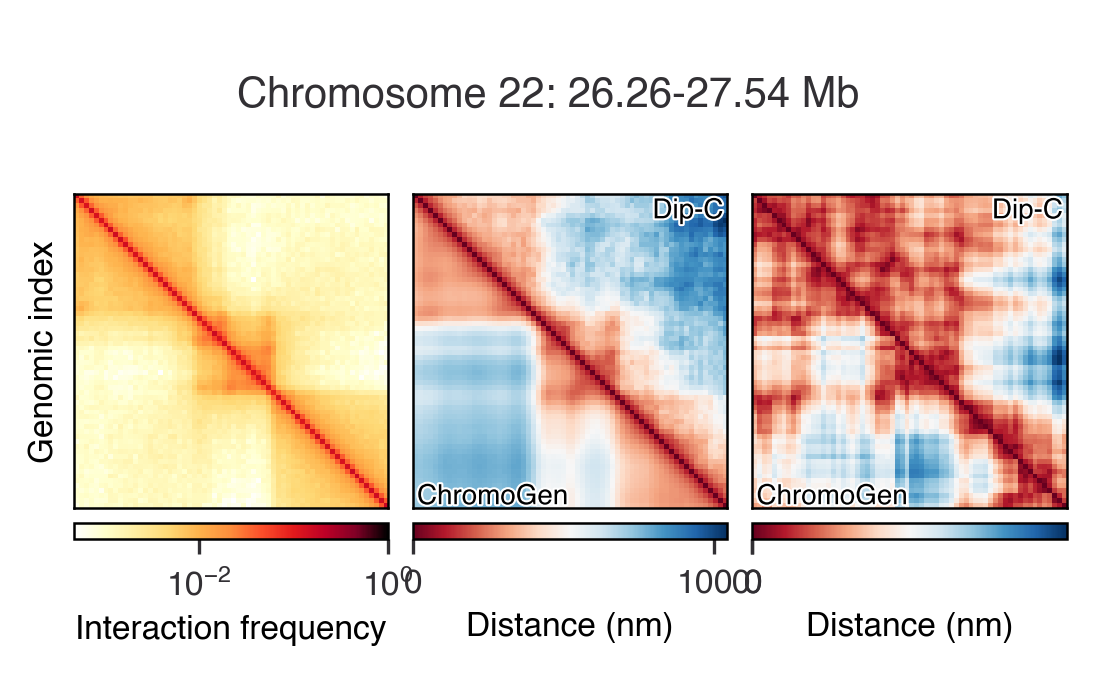

In [6]:
for k,(cell_type, chrom, start_idx, aligned_cgen_idx, aligned_dipc_idx) in enumerate([
    ('GM12878','1',8_680_000,14495,13),
    ('GM12878','1',29_020_000,10778,0),
    ('GM12878','22',26_260_000,18209,0)
]):
    
    fig, ax_hic, ax_median, ax_aligned, cbar_hic, cbar_median, cbar_aligned = \
    make_plot(cell_type, chrom, start_idx, aligned_cgen_idx, aligned_dipc_idx)

    if k == 0:
        part = 'a'
    elif k == 1:
        part = 'b'
    else:
        part = 'c'
        cbar_hic.set_label('Interaction frequency')
        cbar_median.set_label('Distance (nm)')
        cbar_aligned.set_label('Distance (nm)')
    
    fig.savefig(pdf_dir / f'part_{part}.pdf', bbox_inches='tight', transparent=True)

#### Create the DCD files needed for our VMD scripts for the right panel

In [7]:
for k,(cell_type, chrom, start_idx, aligned_cgen_idx, aligned_dipc_idx) in enumerate([
    ('GM12878','1',8_680_000,14495,13),
    ('GM12878','1',29_020_000,14338,38),
    ('GM12878','22',26_260_000,18209,0)
]):

    ###
    # Load the relevant coordinates & grab the structure used for visualization

    # ChromoGen
    f1 = cgen_conformations_dir / cell_type.replace('-','')
    f2 = f1 / f'chrom_{chrom}/start_idx_{start_idx//1000}_cond_scale_5.0_rescaled_phi_8.0.pt'
    f1 = f1 / f'chrom_{chrom}/start_idx_{start_idx//1000}_cond_scale_1.0_rescaled_phi_0.0.pt'
    cgen_coords = ChromoGen.Conformations(f1,drop_invalid_conformations=True).cat(
        ChromoGen.Conformations(f2,drop_invalid_conformations=True)
    )[aligned_cgen_idx]

    # Dip-C
    dipc_coords = ChromoGen.Conformations(config_ds.fetch_specific_coords(chrom,start_idx)[-1])[aligned_dipc_idx]
    
    ###
    # Process

    # Center all coordinates to make VMD work easier
    cgen_coords.center_coordinates_()
    dipc_coords.center_coordinates_()

    # Superpose. Also superpose the reflection since the distance map-to-coordinates 
    # method used in ChromoGen can't account for chirality & reflections are valid
    cgen_coords1 = cgen_coords.clone().superpose(dipc_coords,use_mdtraj=True)
    cgen_coords._values[...,-1]*= -1
    cgen_coords2 = cgen_coords.superpose(dipc_coords,use_mdtraj=True)

    # Choose the reflection that aligns better with the reference
    rmsd1 = cgen_coords1.rmsd(dipc_coords)
    rmsd2 = cgen_coords2.rmsd(dipc_coords)
    if rmsd1 < rmsd2:
        cgen_coords = cgen_coords1
    else:
        cgen_coords = cgen_coords2 # Technically, these should already be the same. But... improved readability, yada yada

    ###
    # Save the aligned structures
    cgen_coords.save_dcd(dcd_data_dir / f'aligned_chrom_{chrom}_{start_idx//1000}_cgen.dcd')
    dipc_coords.save_dcd(dcd_data_dir / f'aligned_chrom_{chrom}_{start_idx//1000}_dipc.dcd')
    